# Step 2: ECFS protocol and Analysis

The goal of this file is to provide all the functions needed to format the dataframe for the ECFS algorithn, and posteiror analysis of the obtained results.

The functions listed below will:
1. Format the dataframe so that it can be imported in MATLAB.
2. Format the MATLAB output to continue the analyisis in Python.
3. Compute the **Network-Community analysis** together with the **h-scores** used for the calculation of entropy, i.e. disorder in the community structure.

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from networkx.algorithms import community
import community
import matplotlib
import itertools

In [2]:
geneID = pd.read_excel("geneID_ens_symbol_KSranked.xlsx")
geneID.head(20)

ensID    symbol
0   ENSMUSG00000028773     Fabp3
1   ENSMUSG00000102433   Gm38050
2   ENSMUSG00000044471   Lncpint
3   ENSMUSG00000071533      Pcnp
4   ENSMUSG00000020863    Luc7l3
5   ENSMUSG00000030771   Micalcl
6   ENSMUSG00000028053     Ash1l
7   ENSMUSG00000086712  AI427809
8   ENSMUSG00000032595     Cdhr4
9   ENSMUSG00000032679     Cd59a
10  ENSMUSG00000036353    P2ry12
11  ENSMUSG00000016921     Srsf6
12  ENSMUSG00000045594      Glb1
13  ENSMUSG00000026365       Cfh
14  ENSMUSG00000033488    Cryzl2
15  ENSMUSG00000000787     Ddx3x
16  ENSMUSG00000029417     Cxcl9
17  ENSMUSG00000029670      Ing3
18  ENSMUSG00000021196      Pfkp
19  ENSMUSG00000031775      Pllp

In [3]:
df_filteredKS = pd.read_csv("df_filteredKS.csv", sep="\t")
df_filteredKS

geneID    G7F_mean  G7FNSen_mean  G7FSen_mean   G7M_mean  \
0    ENSMUSG00000026154    9.374707     12.772968    27.824232   5.671751   
1    ENSMUSG00000101372    1.444587      1.111497     0.371584   0.699926   
2    ENSMUSG00000026087   22.069027     25.173005    43.724768  16.839861   
3    ENSMUSG00000041763   18.230442     11.950132    12.110390  28.941241   
4    ENSMUSG00000025982  112.095088     84.476640    55.605328  83.438708   
..                  ...         ...           ...          ...        ...   
137  ENSMUSG00000031385    0.000000      0.367214     0.398137   0.000000   
138  ENSMUSG00000002014   36.531070     61.966370    94.802257  64.016520   
139  ENSMUSG00000031198   22.257823     26.709863    36.829580  13.182433   
140  ENSMUSG00000025525    1.787333      2.887403     7.121444   3.833947   
141  ENSMUSG00000025289   64.794850    122.431833   114.343833  50.193153   

     G7MNSen_mean  G7MSen_mean    G7S_mean  G7SNSen_mean  G7SSen_mean  ...  \
0       11.260086    16.675180    0.000000      6.299948    16.657781  ...   
1        0.330705     0.364940    1.624852      0.486327     0.348787  ...   
2       20.386269    26.003121   20.099141     31.424203    30.086606  ...   
3       17.719509    14.524426   27.617458     16.755259    17.023425  ...   
4       65.120788    51.364688  120.530328     74.634990    59.653100  ...   
..            ...          ...         ...           ...          ...  ...   
137      0.000000     0.068053    0.000000      0.000000     1.463048  ...   
138     57.620877    83.569053   31.541450     29.319517    29.808617  ...   
139     13.808850    21.667137    8.334765     25.366677    35.125597  ...   
140      3.837358     8.342085    3.408360      8.749270    17.766763  ...   
141     44.132810    48.840410   23.275993     53.697473    72.309847  ...   

     G3SSen_mean   Y3F_mean  Y3FNSen_mean  Y3FSen_mean   Y3M_mean  \
0      45.174186  21.242280     26.628339    33.862152  21.526737   
1       0.114060   0.582884      0.373457     0.367516   0.367600   
2      32.878457  19.962933     27.788901    33.128654  15.660406   
3      11.825596  12.635614     12.746935    11.025465  15.401941   
4      40.601267  87.341269     63.008648    46.958564  61.851565   
..           ...        ...           ...          ...        ...   
137     0.326122   0.000000      0.263454     0.184928   0.000000   
138    85.980737  61.723820    126.512300   155.044933  50.799810   
139    38.596550  38.528550     35.038627    39.704690  20.947253   
140    18.968587   2.519863     12.714293     8.579726   4.221943   
141   131.150733  73.851210    219.008500   250.300933  53.033977   

     Y3MNSen_mean  Y3MSen_mean  Y3SNSen_mean  Y3SSen_mean    Y3S_mean  
0       31.649925    47.899333     26.170418    48.272665    4.519765  
1        0.055509     0.210572      0.539133     0.318045    1.040053  
2       23.192990    32.742092     38.338612    40.461611   11.934976  
3       12.587769    12.309141     21.549588    12.849492   28.855441  
4       74.434975    44.904032     61.191470    50.753543  147.272977  
..            ...          ...           ...          ...         ...  
137      0.000000     0.273452      0.000000     0.247827    0.000000  
138     55.415170    88.717490     31.050667    58.336110   26.443985  
139     17.393723    43.456097     34.126103    43.358643    7.465416  
140      4.453317    18.298710     18.434093    41.276830    3.720032  
141     27.535113    93.463507     84.721693    89.640110   49.543635  

[142 rows x 37 columns]

## 1 Dataframe formatting for MATLAB import

In [4]:
def select_cell_type(df, cell_type = "all"):
    """
    Function that inputs a dataframe and selects cell types according to the input string.
       The input strings can be:
       1. "F" for selecting only FAP cells 
       2. "M" for selecting only Macrophage cells
       3. "S" for selecting only Satellite cells
       3. "all" for selecting all cell types
       Finally, it stores the df into a dataframe named df_output.
    """

    
    if cell_type == "F":
        df_output = df.filter(regex='F|geneID')    
    if cell_type == "M":
        df_output = df.filter(regex='M|geneID')
    if cell_type == "S":
        lst = list(df.filter(regex = 'F|M').columns)
        df_output = df[df.columns.difference(lst)]
        first_col = df_output.pop('geneID')
        df_output.insert(0, 'geneID', first_col)
    if cell_type == "all":
        df_output = df
        
    return df_output

In [5]:
def df_processing(import_file, parent_directory, norm = True, cell_type = 'all'):
    """
    Function that inputs a dataframe of format: rows = genes, columns = cell conditions
    and outputs a df of format: rows = cell conditions, columns = genes 
    that has standarized gene expression values between [0,1] if norm is set to TRUE.
    Also, it adds a class column where a class is indicated as 1 (Sen) or 0 (Nsen). 
    This formatting is necessary because this is the format that is required by 
    the MATLAB ECFS algorithm.
    """
    import pandas as pd
    df = pd.read_csv(import_file, sep="\t")
    df = select_cell_type(df, cell_type)
    
    #0. extracting gene_id and values in different dataframes
    df_geneid = df["geneID"]
    df_geneid = df_geneid.to_frame().reset_index(drop=True)
    df_values = df.drop(["geneID"], axis=1)
    
    #1. standardization of rows in range [0,1] and keeping column names if norm is set tu TRUE    
    
    if norm == True:
        norm = 'normalized'
        import pandas as pd
        from sklearn import preprocessing
 
        x = preprocessing.minmax_scale(df_values.values.T).T
        df_norm = pd.DataFrame(x, columns = df_values.columns)
            
        df_standard = df_geneid.join(df_norm)
    else:
        norm = ''
        df_standard = df
 

    #2. transposing dataframe
    df_transposed = df_standard.T
    header_row = "geneID"
    df_transposed.columns = df_transposed.iloc[0]
    df_transposed = df_transposed.reset_index(drop=False)
    df_transposed = df_transposed.rename(columns={"index": "type"})
    df_transposed = df_transposed.drop([0])
    
    #3. adding class label to the dataframe
    df_class = df_transposed 
    df_class['class'] = [0 if (("NSen" in x) or (len(x)==3)) else 1 for x in df_class['type']]
    df_class.reset_index()
    dataframe = df_class
    df_export = df_class.drop(['type'], axis = 1)
    
    #putting the new file and import file in the created folder
    import os
    directory = str(import_file) + "_" + "ECFS_protocol" 
    path = os.path.join(parent_directory, directory)
    os.makedirs(path)
    filename = import_file[:-4] +'_' + "geneset" + '_' + str(cell_type) + norm +".csv"
    export_file = os.path.join(path, filename)
    df_export.to_csv(export_file, sep='\t')
    
    
    
    path_import_file = os.path.join(path, import_file)
    df.to_csv(path_import_file, sep='\t', index=False)

    return df_export

In [6]:
#df142 = df_processing("df_filteredKS.csv", parent_directory = "df_filteredKS_142", norm = False, cell_type = "all")

## 2 Dataframe formatting for MATLAB export

The ranking that is the output of the MATLAB agorithm has the following format:

|  ranking | feature column number  |
|---|---|
| 1  |  17 |  
| 2  |  83 | 
| 3 |  38 |
| . |  . | 
| . |  .| 
| n-1 |  41 | 
| n |  122 | 

It is important to take into account that the MATLAB indices start from 1, so the feature column number 17 corresponds to the row 16 of the Python dataframe.


The goal is to order the genes from the dataframe in Python, that has the format

| index |  geneID | GF7B  | GF7Sen  | ...  | YSNSen  |
| ---|---|---|---|---|---|
| 0| ENSMUSG00000023198  | 0.23  | 0.76  | 12.1  | 15.8  |
| 1|  ENSMUSG00000027198 | 1.3  | 0.76  | 12.1  | 15.8  |
| 2| ENSMUSG00000043298  | 2.63  | 7.66  | 1.14  | 18.5  |
| ...  |.. | ..  | ..  | ...  |

in the order that is determined by the ranking from the MATLAB output.
Like this:

| index |  geneID | GF7B  | GF7Sen  | ...  | YSNSen  |
| ---|---|---|---|---|---|
| 16| ENSMUSG00000023198  | 0.23  | 0.76  | 12.1  | 15.8  |
| 82| ENSMUSG00000027198 | 1.3  | 0.76  | 12.1  | 15.8  |
| 37| ENSMUSG00000043298  | 2.63  | 7.66  | 1.14  | 18.5  |
| ...  |.. | ..  | ..  | ...  |


In [7]:
def ranking_export(filename, df):
    """
    Function that imports the filename with the ranking in the MATLAB format and the 
    respective dataframe that was used for getting the MATLAB format and exports the ranking.
    It outputs the dictionary of the ranking in format: 'geneID'--> 'ranking'
    """
    
    #import data from excel file
    df_ranking = pd.read_excel(filename, sheet_name='Sheetnew')
    #get the ranking and subtract 1 because of difference in indexing between Matlab and Python
    order_of_ranking = (df_ranking['r']-1).to_list()
    
    #resetting index to df so that geneID can be recognized
    df = df.reset_index(drop=True)
    #reorder the df by the list of rankings from Matlab
    df_ranked = df.reindex(order_of_ranking)
    print(df_ranked)
    
    #create a list of values from 1 to len(df) to assign the rankings
    list_of_ranks = list(range(len(df)+1))[1:]
    #assign a new column to df_ranked that sotres the actual ranking
    df_ranked['ranking'] = list_of_ranks
    #create a new df that has only the geneID and the ranking
    df_all = df_ranked[['geneID', 'ranking']]
    #convert df_all to dictionary
    dict_all = dict(zip(df_all.geneID, df_all.ranking)) 
    
    return df_ranked, df_all

In [8]:
df_ranked, df_all = ranking_export("df_filteredKS_142/df_filteredKS.csv_ECFS_protocol/ranking_df_filteredKS.xls", df_filteredKS)

                 geneID   G7F_mean  G7FNSen_mean  G7FSen_mean   G7M_mean  \
94   ENSMUSG00000028773   1.108826      2.634362     7.292113   1.114405   
10   ENSMUSG00000102433   1.264172      4.773241     5.320926   0.000000   
106  ENSMUSG00000044471  53.471140     29.909353     7.166949  22.672213   
43   ENSMUSG00000071533  10.729073     14.389570     8.495852  10.363422   
18   ENSMUSG00000020863  16.972573     14.361967     8.451580  11.245947   
..                  ...        ...           ...          ...        ...   
140  ENSMUSG00000025525   1.787333      2.887403     7.121444   3.833947   
24   ENSMUSG00000010608  23.077020     20.864160    16.026177  21.245803   
31   ENSMUSG00000021643   1.909945     14.081445    37.102390   2.185018   
114  ENSMUSG00000006315  30.944517     73.472877   123.363850  73.478697   
91   ENSMUSG00000028643  25.712750     28.074680    53.858193  11.353586   

     G7MNSen_mean  G7MSen_mean   G7S_mean  G7SNSen_mean  G7SSen_mean  ...  \
94       0

In [9]:
df_ranked

geneID   G7F_mean  G7FNSen_mean  G7FSen_mean   G7M_mean  \
94   ENSMUSG00000028773   1.108826      2.634362     7.292113   1.114405   
10   ENSMUSG00000102433   1.264172      4.773241     5.320926   0.000000   
106  ENSMUSG00000044471  53.471140     29.909353     7.166949  22.672213   
43   ENSMUSG00000071533  10.729073     14.389570     8.495852  10.363422   
18   ENSMUSG00000020863  16.972573     14.361967     8.451580  11.245947   
..                  ...        ...           ...          ...        ...   
140  ENSMUSG00000025525   1.787333      2.887403     7.121444   3.833947   
24   ENSMUSG00000010608  23.077020     20.864160    16.026177  21.245803   
31   ENSMUSG00000021643   1.909945     14.081445    37.102390   2.185018   
114  ENSMUSG00000006315  30.944517     73.472877   123.363850  73.478697   
91   ENSMUSG00000028643  25.712750     28.074680    53.858193  11.353586   

     G7MNSen_mean  G7MSen_mean   G7S_mean  G7SNSen_mean  G7SSen_mean  ...  \
94       0.000000     6.984152   3.854309      2.837667     4.025069  ...   
10       0.000000     0.966213   0.000000      0.000000     0.000000  ...   
106      9.201572     4.214950  15.337308      3.235999     0.604172  ...   
43      10.460677     8.948537  16.355583     13.633727    11.497847  ...   
18      11.973417     9.386507  19.330207     20.186983    13.063754  ...   
..            ...          ...        ...           ...          ...  ...   
140      3.837358     8.342085   3.408360      8.749270    17.766763  ...   
24      23.084737    23.117717  27.596330     26.042403    19.554510  ...   
31       4.210442     4.482802   0.912461     13.573474    19.661180  ...   
114     66.069950    92.642300  48.150437     89.576413   116.052237  ...   
91      26.141133    40.498547  24.564217     72.955527   147.534233  ...   

      Y3F_mean  Y3FNSen_mean  Y3FSen_mean   Y3M_mean  Y3MNSen_mean  \
94    1.372702      3.080218     6.496544  13.002197      0.000000   
10    0.000000      0.371843     4.617450   1.449223      0.000000   
106  31.290217      5.483048     6.133262  24.466720      5.408345   
43    9.580695      9.364737     8.473849  10.821351     10.569788   
18   10.445293      8.347679     6.340688  15.855947     25.132637   
..         ...           ...          ...        ...           ...   
140   2.519863     12.714293     8.579726   4.221943      4.453317   
24   19.667293     12.242177    12.074580  24.555713     29.936247   
31   12.907783     18.198497    29.491130   4.874796      0.412130   
114  74.774970    111.925190   133.064400  68.892950     37.019037   
91   33.700367     49.901187    63.959053  18.743557     37.249460   

     Y3MSen_mean  Y3SNSen_mean  Y3SSen_mean   Y3S_mean  ranking  
94     41.515963      1.080518    14.369990   3.202665        1  
10      3.798781      0.000000     1.655950   0.000000        2  
106     2.762375      1.169546     1.320244  34.169720        3  
43      6.111948     12.020820     9.713858  12.113660        4  
18      6.403587     14.182250    12.527593  21.817175        5  
..           ...           ...          ...        ...      ...  
140    18.298710     18.434093    41.276830   3.720032      138  
24     12.725873     16.119297    14.031180  28.284780      139  
31      3.007330     10.121464    19.200003   1.775331      140  
114   149.794867    147.247767   215.332733  25.681565      141  
91     49.019170     73.552970   311.684367  47.743640      142  

[142 rows x 38 columns]

In [10]:
df_all

geneID  ranking
94   ENSMUSG00000028773        1
10   ENSMUSG00000102433        2
106  ENSMUSG00000044471        3
43   ENSMUSG00000071533        4
18   ENSMUSG00000020863        5
..                  ...      ...
140  ENSMUSG00000025525      138
24   ENSMUSG00000010608      139
31   ENSMUSG00000021643      140
114  ENSMUSG00000006315      141
91   ENSMUSG00000028643      142

[142 rows x 2 columns]

## 3 Network-community analysis and h-score

In [50]:
def correlation(dataframe):
    """
    Function that inputs a dataframe of selected genes and 
        1. computes correlation values between the genes in the dataframe
        2. plots the correlation matrix (heatmap)
        3. plots the correlation histogram
        4. plots the KDE of the correlation histogram
        5. returns a dataframe of format 'node1' 'node2' 'correlation coefficient'
           stored in the 'links' variable   
    """
    
    #Computing correlation
    import seaborn as sns
    corr = dataframe.corr(method='pearson')   
     

    #Decomment for plotting individual heatmaps for the genes
    #fig, ax = plt.subplots(figsize=(25,25))
    #sns.heatmap(corr, 
    #    xticklabels=corr.columns,
    #    yticklabels=corr.columns)
    #plt.title('Correlation matrix', fontsize=70, loc='left', pad=50)
    #plt.show()


    #Correlation histogram
    import itertools
    list2d = corr.values.tolist()
    merged = list(itertools.chain(*list2d))
    
    #Decomment for plotting histograms for the genes
    #fig, ax = plt.subplots(figsize=(9,5))
    #plt.hist(corr)
    #plt.xlabel('Correlation')
    #plt.ylabel('Frequency')
    #plt.show()


    #Decomment for plotting the distributions of correlation values
    #KDE correlation histogram
    #fig, ax = plt.subplots(figsize=(9,5))
    #plt.title('Distribution of correlation values', fontsize = 'small', pad = 20)
    #plt.xlabel('Correlation')
    #plt.ylabel('Density')
    #sns.distplot(merged, kde=True, norm_hist=True, color = 'skyblue')
    #plot_data = sns.distplot(merged).get_lines()[0].get_data()
    #yarray = plot_data[1]
    #xarray = plot_data[0]
    #min_value = np.where(yarray == plot_data[1][60:70].min())
    #minimum = xarray[min_value]
    #threshold = float(minimum)
    #plt.show()
    
    #Transform it in a links data frame (3 columns only):
    links = corr.stack().reset_index()
    links.columns = ['gene1', 'gene2','corr_value']
    return links

In [17]:
def normalize_corr_values(df):
    """
    Function that normalizes the correlations values to values between 0 and 1.
    """
    maxi = max(df.corr_value)
    mini = min(df.corr_value)
    df["corr_value"] = df.corr_value.apply(lambda x: (x-mini)/(maxi-mini))
    return df

In [38]:
def filtered(df,threshold, thr_upper = 1):
    """Generates a data frame from a given dataframe and filters it removing the
    edges with a weight lower than a given threshold.
    Input:  * df: a dataframe containing 3 columns (source node, target node and
            weight) and a row for each edge
            * threshold: minimum weight that an edge has to have to not being filtered.
    Output: * df_filtered: filtered dataframe, has 3 columns, keyed 'gene1', 'gene2' and 'corr_value' and
    a row for each edge.
    """
    df_filtered=df.loc[ (df['corr_value'] >= threshold) & (df['corr_value'] <= thr_upper) & (df['gene1'] != df['gene2']) ]
    return df_filtered

def network(df):
    """Creates and returns a grap (G) from a dataframe (df) using NetworkX library.
    Input:  * df: dataframe with 3 columns, keyed 'gene1', 'gene2' and 'corr_value' and a row for each
            edge.
    Output: * G: Network graph
    """
    G=nx.from_pandas_edgelist(df, 'gene1', 'gene2', edge_attr = 'corr_value')
    return G

def network_plot(G):
    """Functions that from a given network G, creates the plot representation of this network
    Input:  * G: Network graph
    Output: * network plot
    
    """
    
    pos = nx.spring_layout(G, scale=4)  # double distance between all nodes
    fig, ax = plt.subplots(figsize=(20,20))
    nx.draw(G,pos, with_labels=True, node_color='skyblue', node_size=2000 ,edge_color='grey', alpha=0.8 ,linewidths=0.5, font_size=12)


In [42]:
def louvain(G):
    
    """Implements the Louvain community search algorithm in a graph (G) and returns a
    dictionary of the partitions.
    Input:  * G: a graph generated with NetworkX
    Output: * dic_nodes: a dictionary like {community_number:{'node_1 , ... , node_N'}}
    """

    # Starting with an initial partition of the graph and running the Louvain algorithm for Community Detection
    partition=community.best_partition(G, weight='corr_value') #--> it has to have a weight, otherwise it is just 36 communities (each node is one)    

    values=[partition.get(node) for node in G.nodes()]
    list_com=partition.values()

    # Creating a dictionary like {community_number:list_of_participants}
    dict_nodes={}

    # Populating the dictionary with items
    for each_item in partition.items():
        v= set()
        community_num=each_item[1]
        community_node=each_item[0]
        if community_num in dict_nodes:

            dict_nodes.get(community_num).add(community_node)

        else:
            v.add(community_node)
            dict_nodes.update({community_num:v})

    # Creating a new graph to represent the communities created by the Louvain algorithm
    G_comm=nx.Graph()

    # Populating the data from the node dictionary created earlier
    G_comm.add_nodes_from(dict_nodes)

    # Calculating the total number of communities
    #print("Total number of Communities=", len(G_comm.nodes()))
    return dict_nodes, partition

In [40]:
def plot_communities(G): 
    """
    Function that takes a network, computes the communities and plots them .
    """ 
    dict_nodes,partition = louvain(G) 
    pos = nx.spring_layout(G)
  
    #list of correlation values
    durations = [i['corr_value'] for i in dict(G.edges).values()]
   
    #plotting 
    plt.figure(figsize=(15, 10))
    plt.axis('off')
    nx.draw_networkx_nodes(G, pos, node_size=1800, cmap=plt.cm.RdYlBu, node_color=list(partition.values()))    
    nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color=durations, edge_cmap=plt.cm.Blues, width=2)  
    nx.draw_networkx_labels(G,pos, font_size=7, font_color='black', font_weight='bold', alpha=1.0)
    plt.show()

In [57]:
def h_value(df, n):
    """
    Function that computes the h-score both cell-type-wise and community wise.
    In the case the number of communities is not 3, the h-score is set to 0.
    """
    

    dataframe = correlation(df) #where df will be a dataframe where there are k selected genes

    G = network(dataframe)
  
    dict_nodes, partition = louvain(G) 
    sen = []
    nsen = []
    bas = []
    H_comms = []    
    
    for comm in dict_nodes.values():

        count_sen = 0
        count_nsen = 0
        count_bas = 0
        
        for string in comm:
            #counting sen cells in each community
            if "FSen" in string:
                count_sen +=1
            elif "SSen" in string:
                count_sen +=1
            elif "MSen" in string:
                count_sen+=1
                
            #counting nsen cells in each community
            elif "FNSen" in string:
                count_nsen +=1
            elif "SNSen" in string:
                count_nsen +=1
            elif "MNSen" in string:
                count_nsen+=1
                
            #counting bas cells in each community
            elif "F_" in string:
                count_bas +=1
            elif "S_" in string:
                count_bas +=1
            elif "M_" in string:
                count_bas +=1
            
        
        #computing entropy celltype-wise
        prob_sen_celltype = count_sen/12
        prob_nsen_celltype = count_nsen/12
        prob_bas_celltype = count_bas/12

        sen.append(prob_sen_celltype)
        nsen.append(prob_nsen_celltype)
        bas.append(prob_bas_celltype)
        
        #computing entropy community-wise
        prob_sen_comm = count_sen/len(comm)
        prob_nsen_comm = count_nsen/len(comm)
        prob_bas_comm = count_bas/len(comm)
        #ensure that no "prob" value is equal to 0, because log(0) is undefined
        if prob_sen_comm == 0:
            pS = 0
        else:
            pS = prob_sen_comm*np.log(prob_sen_comm)
        if prob_nsen_comm == 0:
            pN = 0
        else:
            pN = prob_nsen_comm*np.log(prob_nsen_comm)       
        if prob_bas_comm == 0:
            pB = 0
        else:
            pB = prob_bas_comm*np.log(prob_bas_comm) 
        
        H_comm = -1*(pS+pN+pB) 
    
        #computing entropy community-wise
        #storing entropy values for each community in a list named H_comms
        H_comms.append(H_comm)
    
    
    ncomms = len(dict_nodes)
    H_comm_total = np.sum(H_comms)
    
    #computing the entropy celltype-wise
    H_sen = -sum([p*np.log(p) if p !=0 else 0 for p in sen])
    H_nsen = -sum([p*np.log(p) if p !=0 else 0 for p in nsen])
    H_bas = -sum([p*np.log(p) if p !=0 else 0 for p in bas])
    H_celltype_total = H_sen + H_nsen + H_bas
    
    H_total = H_comm_total + H_celltype_total

    #calculating maximums
    H_celltype_max = -3*np.log(1/12)
    H_comm_max = -3*((1/3)*np.log(1/3))
 
    if ncomms == 3:
        h = (H_celltype_max-H_total)/H_celltype_max
    else:
        h = 0 
    return abs(round(h,4)), len(dict_nodes), dict_nodes 

In [64]:
def selecting_genes(rel_path, n, fig_out):
    """
    Function that perfoms the genes selection and does the NC analysis and H-score evaluation for every geneset,
    starting from the [top1] gene then the [top1,top2], then [top1,top2,top3] and so on.
    
    input:  *rel_path:relative path to the directory where the files for the analysis are located
            *n: number of senescent cells considered in computing the H-score (default=12)
           
    output: *fig_out: filename that we want to assign to the output figure
    """
    
    import os
    
    #finding the file with the dataframe for extracting top genes in order
    for file in os.listdir(rel_path):
        if  not file.startswith('.') and not file.endswith("_all.csv") and not file.endswith(".xls"):
            df = pd.read_csv(file, sep="\t")
    
    #finding the file with the ranking file from MATLAB
    for file in os.listdir(rel_path):
        if file.endswith(".xls"):
            ranking_filename = file
    

    ranking_filename = os.path.join(rel_path, ranking_filename)
    df_ranked, df_all = ranking_export(ranking_filename, df)
    
    
    h_list = []
    genes_list=[]
    n_of_com_list = []
    
    tuple_list = []
    for genes in range (6,100): 

    
        df_all["geneID"]
        
        list_of_selected_genes = df_all['geneID'].head(genes).values.tolist()
        df_selected = df[df['geneID'].isin(list_of_selected_genes)]
        
        
        h, number_of_comm, dict_nodes = h_value(df_selected, n)
        h_list.append(h)
        genes_list.append(genes)
        n_of_com_list.append(number_of_comm)
        tuple_list.append((genes,round(h,3), dict_nodes, number_of_comm))
    
    
    fig, ax1 = plt.subplots()
    
    #plot h parameter
    color = 'tab:red'
    ax1.set_xlabel('number of selected genes')
    ax1.set_ylabel('h parameter', color=color)
    ax1.scatter(genes_list, h_list, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_ylim([-0.1, 1.2])


    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    
    #plot communities
    color = 'tab:blue'
    ax2.set_ylabel('number of communities', color=color)  # we already handled the x-label with ax1
    ax2.scatter(genes_list, n_of_com_list, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim([-0.1, 10])
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
  
    
    plt.title("Senescent cell selection performance")
    filename_output_img = os.path.join(rel_path, fig_out)
    plt.savefig(filename_output_img, dpi=300, bbox_inches = "tight")
    plt.show()
    
    tuple_df= pd.DataFrame(tuple_list, columns=['num_of_genes', 'h_score', 'comm_structure', 'number_of_comm'])

    return tuple_df, rel_path

In [65]:
df_ranked

geneID   G7F_mean  G7FNSen_mean  G7FSen_mean   G7M_mean  \
94   ENSMUSG00000028773   1.108826      2.634362     7.292113   1.114405   
10   ENSMUSG00000102433   1.264172      4.773241     5.320926   0.000000   
106  ENSMUSG00000044471  53.471140     29.909353     7.166949  22.672213   
43   ENSMUSG00000071533  10.729073     14.389570     8.495852  10.363422   
18   ENSMUSG00000020863  16.972573     14.361967     8.451580  11.245947   
..                  ...        ...           ...          ...        ...   
140  ENSMUSG00000025525   1.787333      2.887403     7.121444   3.833947   
24   ENSMUSG00000010608  23.077020     20.864160    16.026177  21.245803   
31   ENSMUSG00000021643   1.909945     14.081445    37.102390   2.185018   
114  ENSMUSG00000006315  30.944517     73.472877   123.363850  73.478697   
91   ENSMUSG00000028643  25.712750     28.074680    53.858193  11.353586   

     G7MNSen_mean  G7MSen_mean   G7S_mean  G7SNSen_mean  G7SSen_mean  ...  \
94       0.000000     6.984152   3.854309      2.837667     4.025069  ...   
10       0.000000     0.966213   0.000000      0.000000     0.000000  ...   
106      9.201572     4.214950  15.337308      3.235999     0.604172  ...   
43      10.460677     8.948537  16.355583     13.633727    11.497847  ...   
18      11.973417     9.386507  19.330207     20.186983    13.063754  ...   
..            ...          ...        ...           ...          ...  ...   
140      3.837358     8.342085   3.408360      8.749270    17.766763  ...   
24      23.084737    23.117717  27.596330     26.042403    19.554510  ...   
31       4.210442     4.482802   0.912461     13.573474    19.661180  ...   
114     66.069950    92.642300  48.150437     89.576413   116.052237  ...   
91      26.141133    40.498547  24.564217     72.955527   147.534233  ...   

      Y3F_mean  Y3FNSen_mean  Y3FSen_mean   Y3M_mean  Y3MNSen_mean  \
94    1.372702      3.080218     6.496544  13.002197      0.000000   
10    0.000000      0.371843     4.617450   1.449223      0.000000   
106  31.290217      5.483048     6.133262  24.466720      5.408345   
43    9.580695      9.364737     8.473849  10.821351     10.569788   
18   10.445293      8.347679     6.340688  15.855947     25.132637   
..         ...           ...          ...        ...           ...   
140   2.519863     12.714293     8.579726   4.221943      4.453317   
24   19.667293     12.242177    12.074580  24.555713     29.936247   
31   12.907783     18.198497    29.491130   4.874796      0.412130   
114  74.774970    111.925190   133.064400  68.892950     37.019037   
91   33.700367     49.901187    63.959053  18.743557     37.249460   

     Y3MSen_mean  Y3SNSen_mean  Y3SSen_mean   Y3S_mean  ranking  
94     41.515963      1.080518    14.369990   3.202665        1  
10      3.798781      0.000000     1.655950   0.000000        2  
106     2.762375      1.169546     1.320244  34.169720        3  
43      6.111948     12.020820     9.713858  12.113660        4  
18      6.403587     14.182250    12.527593  21.817175        5  
..           ...           ...          ...        ...      ...  
140    18.298710     18.434093    41.276830   3.720032      138  
24     12.725873     16.119297    14.031180  28.284780      139  
31      3.007330     10.121464    19.200003   1.775331      140  
114   149.794867    147.247767   215.332733  25.681565      141  
91     49.019170     73.552970   311.684367  47.743640      142  

[142 rows x 38 columns]

                 geneID   G7F_mean  G7FNSen_mean  G7FSen_mean   G7M_mean  \
94   ENSMUSG00000028773   1.108826      2.634362     7.292113   1.114405   
10   ENSMUSG00000102433   1.264172      4.773241     5.320926   0.000000   
106  ENSMUSG00000044471  53.471140     29.909353     7.166949  22.672213   
43   ENSMUSG00000071533  10.729073     14.389570     8.495852  10.363422   
18   ENSMUSG00000020863  16.972573     14.361967     8.451580  11.245947   
..                  ...        ...           ...          ...        ...   
140  ENSMUSG00000025525   1.787333      2.887403     7.121444   3.833947   
24   ENSMUSG00000010608  23.077020     20.864160    16.026177  21.245803   
31   ENSMUSG00000021643   1.909945     14.081445    37.102390   2.185018   
114  ENSMUSG00000006315  30.944517     73.472877   123.363850  73.478697   
91   ENSMUSG00000028643  25.712750     28.074680    53.858193  11.353586   

     G7MNSen_mean  G7MSen_mean   G7S_mean  G7SNSen_mean  G7SSen_mean  ...  \
94       0

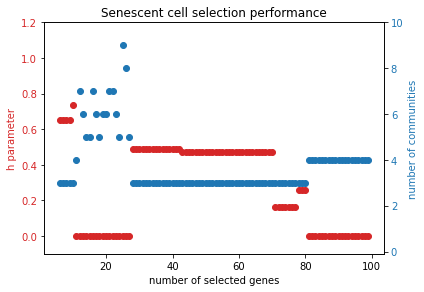

In [60]:
tuple_df, rel_path = selecting_genes("df_filteredKS_142/df_filteredKS.csv_ECFS_protocol", 12, 'hval_142KSfiltered.png')

In [61]:
tuple_df.head(20)

num_of_genes  h_score                                     comm_structure  \
0              6    0.654  {0: {'Y3S_mean', 'G3M_mean', 'Y3M_mean', 'G3F_...   
1              7    0.654  {0: {'Y3S_mean', 'G3M_mean', 'Y3M_mean', 'G3F_...   
2              8    0.654  {0: {'Y3S_mean', 'G3M_mean', 'Y3M_mean', 'G3F_...   
3              9    0.654  {0: {'Y3S_mean', 'G3M_mean', 'Y3M_mean', 'G3F_...   
4             10    0.737  {1: {'Y3S_mean', 'G3M_mean', 'Y3M_mean', 'G3F_...   
5             11    0.000  {0: {'Y3S_mean', 'G3F_mean', 'G3S_mean', 'G7FN...   
6             12    0.000  {3: {'Y3S_mean', 'G3F_mean', 'G3S_mean', 'G7FN...   
7             13    0.000  {0: {'G3F_mean', 'G7FNSen_mean', 'G7F_mean', '...   
8             14    0.000  {4: {'G3M_mean', 'Y3M_mean', 'G3F_mean', 'Y7M_...   
9             15    0.000  {0: {'G3M_mean', 'Y3M_mean', 'G3F_mean', 'Y7M_...   
10            16    0.000  {4: {'G3M_mean', 'Y3M_mean', 'G3F_mean', 'Y7M_...   
11            17    0.000  {4: {'G3M_mean', 'Y3M_mean', 'G3F_mean', 'Y7M_...   
12            18    0.000  {0: {'G3M_mean', 'Y3M_mean', 'G3F_mean', 'Y7M_...   
13            19    0.000  {0: {'G3M_mean', 'Y3M_mean', 'G3F_mean', 'Y7M_...   
14            20    0.000  {5: {'G3M_mean', 'Y3M_mean', 'G3F_mean', 'Y7M_...   
15            21    0.000  {5: {'G3M_mean', 'Y3M_mean', 'G3F_mean', 'Y7M_...   
16            22    0.000  {3: {'G3M_mean', 'Y3M_mean', 'G3F_mean', 'Y7M_...   
17            23    0.000  {1: {'G3SNSen_mean', 'G3F_mean', 'G3MNSen_mean...   
18            24    0.000  {0: {'G3SNSen_mean', 'G3F_mean', 'G3MNSen_mean...   
19            25    0.000  {6: {'G3SNSen_mean', 'G3F_mean', 'G3S_mean', '...   

    number_of_comm  
0                3  
1                3  
2                3  
3                3  
4                3  
5                4  
6                7  
7                6  
8                5  
9                5  
10               7  
11               6  
12               5  
13               6  
14               6  
15               7  
16               7  
17               6  
18               5  
19               9

We see that the best h-score is obtained for the top 10 genes.

In [62]:
top10genes_comm = tuple_df.comm_structure.loc[4]

In [63]:
top10genes_comm

{1: {'G3F_mean',
  'G3M_mean',
  'G3S_mean',
  'G7FNSen_mean',
  'G7F_mean',
  'G7MNSen_mean',
  'G7M_mean',
  'G7S_mean',
  'Y3F_mean',
  'Y3M_mean',
  'Y3S_mean',
  'Y7F_mean',
  'Y7M_mean',
  'Y7S_mean'},
 0: {'G3MSen_mean',
  'G3SSen_mean',
  'G7FSen_mean',
  'G7MSen_mean',
  'Y3FSen_mean',
  'Y3MSen_mean',
  'Y3SSen_mean',
  'Y7FSen_mean',
  'Y7MSen_mean'},
 2: {'G3FNSen_mean',
  'G3FSen_mean',
  'G3MNSen_mean',
  'G3SNSen_mean',
  'G7SNSen_mean',
  'G7SSen_mean',
  'Y3FNSen_mean',
  'Y3MNSen_mean',
  'Y3SNSen_mean',
  'Y7FNSen_mean',
  'Y7MNSen_mean',
  'Y7SNSen_mean',
  'Y7SSen_mean'}}